In [ ]:
# Import libraries
!pip install pmdarima

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pmdarima import auto_arima

In [ ]:
import pandas as pd

file_path = '/content/Apple_stock.csv'
# Read the CSV file, skipping the first row (metadata)
stock_data = pd.read_csv(file_path, skiprows=1)

# Drop the second row, which contains NaN in all columns
stock_data.drop(index=0, inplace=True)

# Print column names to inspect them
print("Column names:", stock_data.columns)

# Rename the first column (which is currently unnamed) to 'Date'
stock_data.rename(columns={stock_data.columns[0]: 'Date'}, inplace=True)

stock_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

# Set 'Date' as the index
stock_data.set_index('Date', inplace=True)
numeric_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
stock_data[numeric_columns] = stock_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

stock = stock_data['Close']

# Check for missing values
print("Missing values in 'Close':", stock.isnull().sum())
print(stock.head())

Column names: Index(['Ticker', 'AAPL', 'AAPL.1', 'AAPL.2', 'AAPL.3', 'AAPL.4', 'AAPL.5'], dtype='object')
Missing values in 'Close': 0
Date
2014-08-01    24.032499
2014-08-04    23.897499
2014-08-05    23.780001
2014-08-06    23.740000
2014-08-07    23.620001
Name: Close, dtype: float64


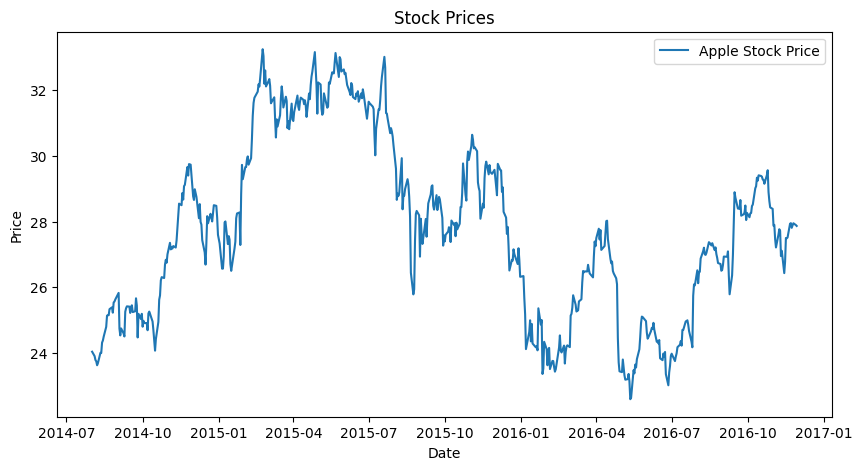

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(stock, label='Apple Stock Price')  # Replace ticker with the stock name directly
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Check for stationarity using Augmented Dickey-Fuller (ADF) Test
result = adfuller(stock)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] > 0.05:
    print("The series is non-stationary. Differencing will be applied.")
    stock_diff = stock.diff().dropna()
else:
    print("The series is stationary.")
    stock_diff = stock


ADF Statistic: -2.1682503299850526
p-value: 0.2179698405819862
The series is non-stationary. Differencing will be applied.


In [ ]:
print(stock.head())

Date
2014-08-01    24.032499
2014-08-04    23.897499
2014-08-05    23.780001
2014-08-06    23.740000
2014-08-07    23.620001
Name: Close, dtype: float64


In [ ]:
stock.head()

,Close
Date,
2014-08-01,24.032499
2014-08-04,23.897499
2014-08-05,23.780001
2014-08-06,23.740000
2014-08-07,23.620001


In [ ]:
stock.tail()

,Close
Date,
2016-11-22,27.950001
2016-11-23,27.807501
2016-11-25,27.947500
2016-11-28,27.892500
2016-11-29,27.865000


In [ ]:
!pip install pmdarima

In [ ]:

if isinstance(stock, pd.Series):
    stock = stock.to_frame()

# Extract and rename columns dynamically
if 'Close' in stock.columns:
    stock = stock[['Close']].rename(columns={'Close': 'Price'})
elif ticker in stock.columns:  # If ticker name is used as the column
    stock = stock[[ticker]].rename(columns={ticker: 'Price'})
else:
    raise KeyError("Unable to find the price column in the downloaded data.")

# Reset index to create a proper DataFrame
stock.reset_index(inplace=True)
stock.columns = ['Date', 'Price']

# Display the first few rows
print(stock.head())


        Date      Price
0 2014-08-01  24.032499
1 2014-08-04  23.897499
2 2014-08-05  23.780001
3 2014-08-06  23.740000
4 2014-08-07  23.620001


In [ ]:
stock.columns

Index(['Date', 'Price'], dtype='object')

In [ ]:
# ========== FEATURE ENGINEERING SECTION ==========

def add_technical_indicators(data):
    """
    Add technical indicators to the DataFrame
    """
    data = data.copy()

    # Moving Averages
    data['MA10'] = data['Price'].rolling(window=10).mean()  # New 10-day MA
    data['MA20'] = data['Price'].rolling(window=20).mean()  # Existing 20-day MA
    data['MA50'] = data['Price'].rolling(window=50).mean()  # Existing 50-day MA

    # Lagged features
    data['Lag1'] = data['Price'].shift(1)
    data['Lag2'] = data['Price'].shift(2)

    # Additional indicators
    # Rate of Change (ROC)
    data['ROC'] = data['Price'].pct_change() * 100

    # Simple Momentum
    data['Momentum'] = data['Price'] - data['Price'].shift(10)

    # Drop NaN values after creating indicators
    data.dropna(inplace=True)

    return data

# Split into train and test sets (80-20 split)
train_size = int(len(stock) * 0.8)
train_data = stock[:train_size]
test_data = stock[train_size:]

# Reset index to avoid alignment issues
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Apply feature engineering
train_data = add_technical_indicators(train_data)
test_data = add_technical_indicators(test_data)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the scaler (you can use StandardScaler if preferred)
scaler = MinMaxScaler()

# Update the scaling section
scaled_columns = ['Price', 'MA10', 'MA20', 'MA50', 'Lag1', 'Lag2', 'ROC', 'Momentum']

# Fit and transform the training data
scaled_data = scaler.fit_transform(train_data[scaled_columns].values)

# Similarly, scale the test data (only transform)
test_scaled = scaler.transform(test_data[scaled_columns].values)

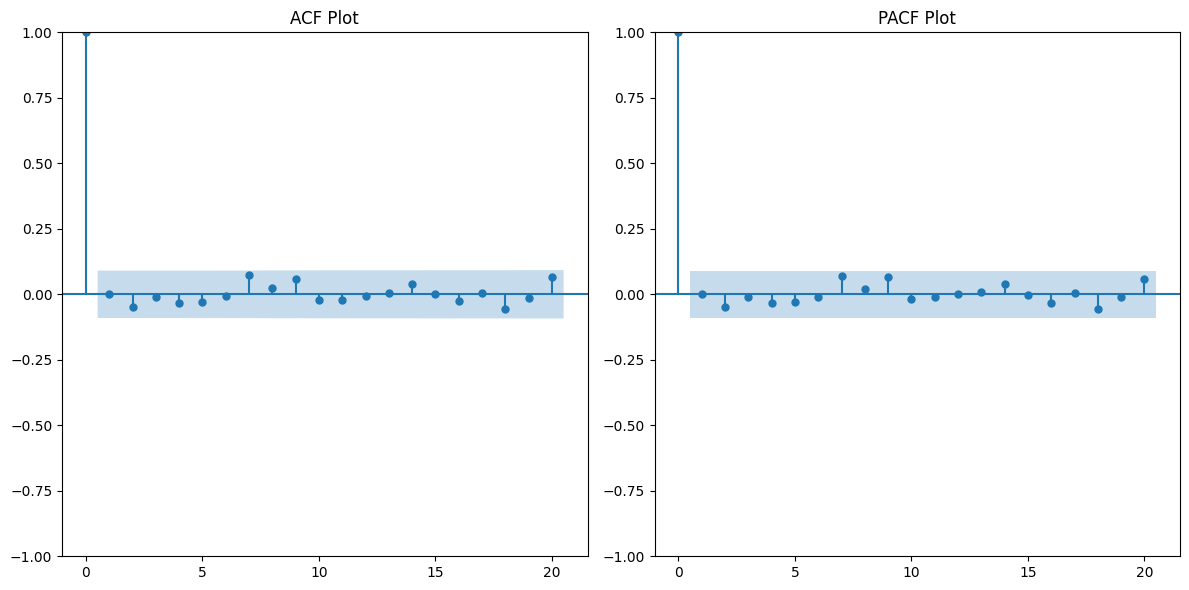

In [ ]:
# Step 5: Train-Test Split
train, test = stock_diff[:train_size], stock_diff[train_size:]

# Step 6: ACF and PACF Plot (Optional for Model Selection)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train, lags=20, ax=plt.gca())
plt.title("ACF Plot")
plt.subplot(122)
plot_pacf(train, lags=20, ax=plt.gca())
plt.title("PACF Plot")
plt.tight_layout()
plt.show()

In [ ]:
# Enhanced Auto ARIMA setup with larger search space for hyperparameters
auto_model = auto_arima(
    train,  # Target variable
    start_p=0, max_p=10,      # Larger range for p
    start_q=0, max_q=10,      # Larger range for q
    start_d=0, max_d=2,       # Differencing order search
    seasonal=True,            # Enable seasonal ARIMA
    m=12,                     # Monthly seasonality
    start_P=0, max_P=3,       # Seasonal AR(1,2,3)
    start_Q=0, max_Q=3,       # Seasonal MA(1,2,3)
    stepwise=True,            # Stepwise search to avoid overfitting
    trace=True,                # Print model progress
    error_action='ignore',
    suppress_warnings=True,   # Suppress warnings to improve readability
    max_order=20,             # Cap complexity
    maxiter=100,              # Max iterations to explore models
    n_jobs=-1                 # Use multiple cores for faster computation
)

print("\nBest ARIMA Model Summary:")
print(auto_model.summary())

# Fit the best ARIMA model to the training data
best_arima_model = auto_model.fit(train)

# Forecast the future values
forecast = best_arima_model.predict(n_periods=len(test))

# Evaluate model performance
mae = mean_absolute_error(test, forecast)
rmse = math.sqrt(mean_squared_error(test, forecast))

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=581.226, Time=0.22 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=585.213, Time=0.66 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=585.214, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=579.227, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=583.214, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=583.215, Time=0.27 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=584.929, Time=1.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=583.224, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=583.224, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=584.728, Time=0.38 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 3.700 seconds

Best ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  470
Model:                        SARI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
print("\nModel Evaluation:")
print(f"Enhanced Auto ARIMA MAE: {mae:.5f}")
print(f"Enhanced Auto ARIMA RMSE: {rmse:.5f}")


Model Evaluation:
Enhanced Auto ARIMA MAE: 0.23479
Enhanced Auto ARIMA RMSE: 0.33983


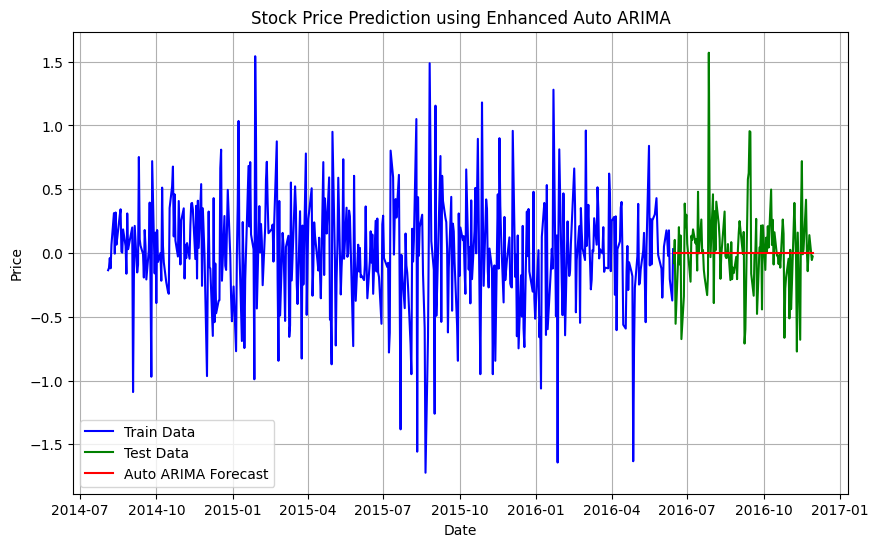

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train Data', color='blue')
plt.plot(test, label='Test Data', color='green')
plt.plot(test.index, forecast, label='Auto ARIMA Forecast', color='red')
plt.title('Stock Price Prediction using Enhanced Auto ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - loss: 0.1007 - val_loss: 0.1026
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0451 - val_loss: 0.0555
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0333 - val_loss: 0.0528
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0280 - val_loss: 0.0388
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0277 - val_loss: 0.0399
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0233 - val_loss: 0.0330
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0256 - val_loss: 0.0525
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0242 - val_loss: 0.0409
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0211 - val_loss: 0.0273
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0210 - val_loss: 0.0257
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.0195 - val_loss: 0.0272
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 0.0185 - val_loss: 0.02

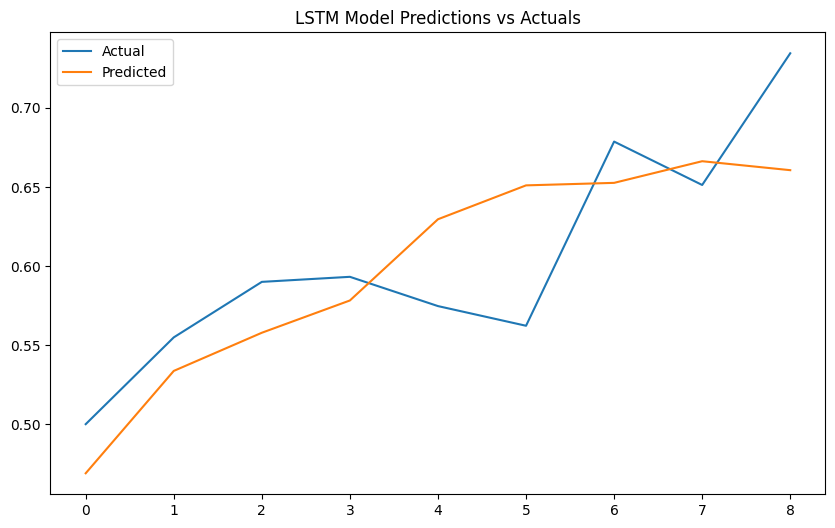

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Check for enough data and clean
if len(stock) < 2:
    raise ValueError("Not enough data to split into train and test sets.")

stock.dropna(inplace=True)

# Split data (80-20 split)
train_size = int(len(stock) * 0.8)
train_data = stock[:train_size]
test_data = stock[train_size:]

# Add technical indicators
train_data = add_technical_indicators(train_data)
test_data = add_technical_indicators(test_data)

# Normalize data
# Drop non-numeric columns before scaling
numeric_train_data = train_data.select_dtypes(include=[np.number])
numeric_test_data = test_data.select_dtypes(include=[np.number])

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(numeric_train_data)
scaled_test_data = scaler.transform(numeric_test_data)

# Ensure datetime is preserved for any future use
train_data = train_data.reset_index(drop=True)  # To match indices if needed
test_data = test_data.reset_index(drop=True)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

seq_length = 60  # Use 60 time steps
X_train, y_train = create_sequences(scaled_train_data, seq_length)
X_test, y_test = create_sequences(scaled_test_data, seq_length)

# Model architecture
model = Sequential([
    Bidirectional(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.2),
    Bidirectional(LSTM(50, activation='relu')),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LSTM Model Predictions vs Actuals')
plt.show()

In [ ]:
# Ensure that both ARIMA and LSTM predictions have the same length
forecast_aligned = forecast[-len(y_pred):]  # Slice ARIMA to match LSTM length

In [ ]:
# Flatten y_pred
y_pred = y_pred.flatten()

# Add the two arrays
hybrid_forecast_additive = forecast_aligned + y_pred

# Print result
print(hybrid_forecast_additive)

578    0.468946
579    0.533673
580    0.557807
581    0.578216
582    0.629575
583    0.650998
584    0.652584
585    0.666273
586    0.660608
dtype: float64


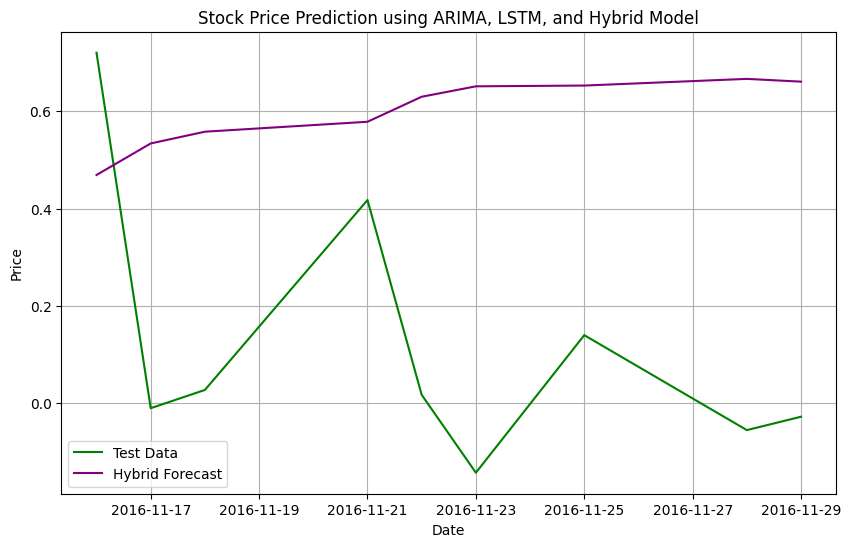

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test.index[-len(y_pred):], test[-len(y_pred):], label='Test Data', color='green')  # Slice test data for correct length
plt.plot(test.index[-len(y_pred):], hybrid_forecast_additive, label='Hybrid Forecast', color='purple')  # Hybrid predictions
plt.title('Stock Price Prediction using ARIMA, LSTM, and Hybrid Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Evaluate the hybrid model (Additive)
mae_hybrid = mean_absolute_error(test[-len(y_pred):], hybrid_forecast_additive)
rmse_hybrid = math.sqrt(mean_squared_error(test[-len(y_pred):], hybrid_forecast_additive))

In [ ]:
# Print the hybrid model performance
print(f"Hybrid MAE: {mae_hybrid:.5f}")
print(f"Hybrid RMSE: {rmse_hybrid:.5f}")

Hybrid MAE: 0.53481
Hybrid RMSE: 0.57022


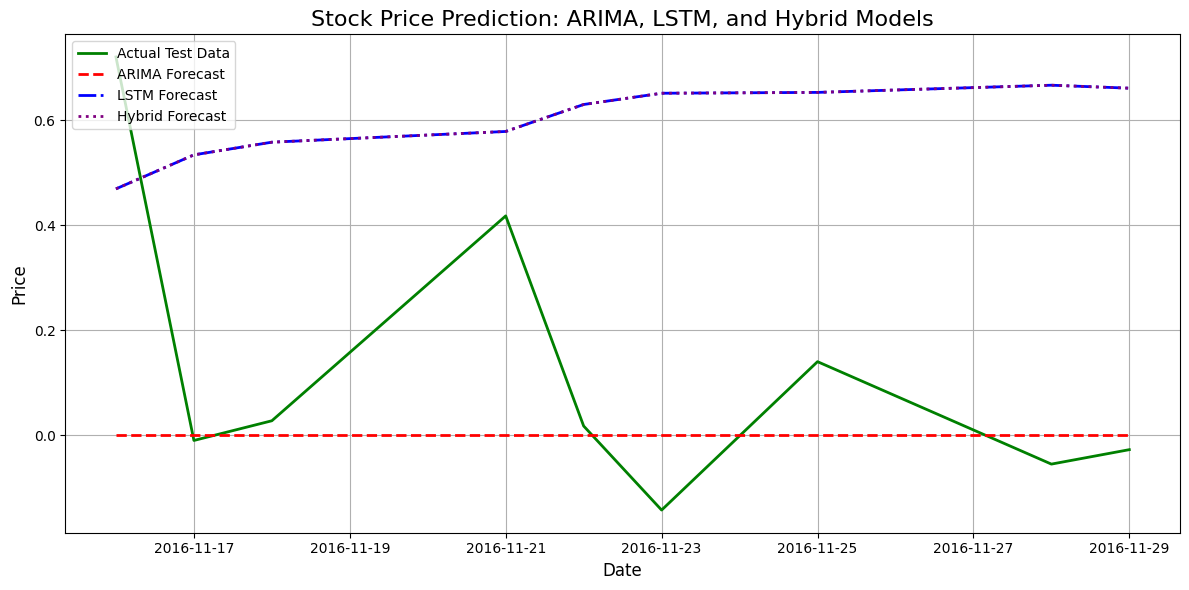

In [ ]:
# Plot the results of the ARIMA, LSTM, and Hybrid models alongside actual test data
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(test.index[-len(y_pred):], test[-len(y_pred):], label='Actual Test Data', color='green', linewidth=2)

# Plot ARIMA forecast
plt.plot(test.index[-len(y_pred):], forecast_aligned, label='ARIMA Forecast', color='red', linestyle='--', linewidth=2)

# Plot LSTM forecast
plt.plot(test.index[-len(y_pred):], y_pred, label='LSTM Forecast', color='blue', linestyle='-.', linewidth=2)

# Plot Hybrid forecast
plt.plot(test.index[-len(y_pred):], hybrid_forecast_additive, label='Hybrid Forecast', color='purple', linestyle=':', linewidth=2)

# Adding titles and labels
plt.title('Stock Price Prediction: ARIMA, LSTM, and Hybrid Models', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the MAE and RMSE for each model
mae_arima = mean_absolute_error(test[-len(y_pred):], forecast_aligned)
rmse_arima = math.sqrt(mean_squared_error(test[-len(y_pred):], forecast_aligned))

mae_lstm = mean_absolute_error(test[-len(y_pred):], y_pred)
rmse_lstm = math.sqrt(mean_squared_error(test[-len(y_pred):], y_pred))

mae_hybrid = mean_absolute_error(test[-len(y_pred):], hybrid_forecast_additive)
rmse_hybrid = math.sqrt(mean_squared_error(test[-len(y_pred):], hybrid_forecast_additive))

# Print the performance metrics for each model
print(f"ARIMA MAE: {mae_arima:.5f}, ARIMA RMSE: {rmse_arima:.5f}")
print(f"LSTM MAE: {mae_lstm:.5f}, LSTM RMSE: {rmse_lstm:.5f}")
print(f"Hybrid MAE: {mae_hybrid:.5f}, Hybrid RMSE: {rmse_hybrid:.5f}")

ARIMA MAE: 0.17306, ARIMA RMSE: 0.28627
LSTM MAE: 0.53481, LSTM RMSE: 0.57022
Hybrid MAE: 0.53481, Hybrid RMSE: 0.57022
